In [27]:
import tonic
import tonic.transforms as TT
import torch
from torch.nn import functional as F

torch.set_grad_enabled(False)

import model
import importlib

importlib.reload(model)
from model import PleiadesClassifier

In [28]:
transform = TT.Compose(
    [
        TT.CropTime(max=1500000 - 1),
        TT.ToFrame(
            tonic.datasets.DVSGesture.sensor_size,
            time_window=10000,
            include_incomplete=True,
        ),
    ]
)

dataset = tonic.datasets.DVSGesture(".", train=False, transform=transform)

In [29]:
gesture_net = PleiadesClassifier(
    in_channels=2,
    num_classes=10,
    channels=[8, 16, 32, 48, 64, 80, 96, 112, 128, 256],
    features=256,
    depthwises=[False, False, True, True, True],
    kernel_size=(3, 3, 10),
    stride=(2, 2, 1),
    padding=(1, 1, 0),
)
gesture_net.eval()

weights = torch.load("dvs128_ckpt.pt")
gesture_net.load_state_dict(weights)

<All keys matched successfully>

In [35]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=8, drop_last=False)
gesture_net = gesture_net.cuda()
offset = 44  # the causal context window of the network

predictions, labels = [], []
for events, label in dataloader:
    events = events.float().cuda().moveaxis(1, -1)
    events = F.pad(events, (offset, 0))
    predictions.append(gesture_net(events).argmax(1).detach().cpu())
    labels.append(label)

predictions, labels = torch.cat(predictions), torch.cat(labels)

mask = labels != 10
labels = labels[mask]
predictions = predictions[mask]

In [36]:
accs = []
for latency in range(predictions.shape[-1]):
    if latency <= offset:
        pred = predictions[:, latency]
    else:
        pred = predictions[:, offset:].mode(-1)[0]
    acc = (pred == labels).float().mean()
    accs.append(acc)
accs = torch.stack(accs)

Text(0, 0.5, 'accuracy')

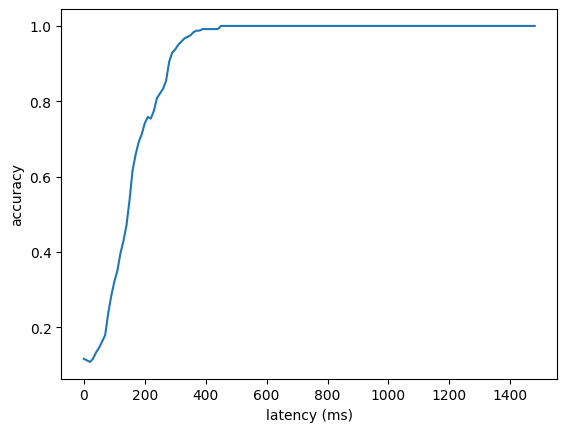

In [38]:
from matplotlib import pyplot as plt

plt.plot(torch.arange(len(accs)) * 10, accs)
plt.xlabel("latency (ms)")
plt.ylabel("accuracy")